# Análise da Média Móvel - Lula 2026

Carregamento e visualização da média móvel de 31 dias para as pesquisas de intenção de voto do Lula

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime, timedelta

# Configurar estilo
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 7)

In [27]:
# Carregar dados JSON
with open('public/pesquisas_2026_normalizado.json', 'r', encoding='utf-8') as f:
    dados = json.load(f)

# Converter para DataFrame
df = pd.DataFrame(dados)

# Expandir candidatos
candidatos_df = pd.json_normalize(df['candidatos'])
df = pd.concat([df.drop('candidatos', axis=1), candidatos_df], axis=1)

print(f"Dados carregados: {df.shape[0]} pesquisas")
print(f"Período: {df['data'].iloc[-1]} a {df['data'].iloc[0]}")

Dados carregados: 64 pesquisas
Período: 29 Sep – 3 Oct 2023 a 15–19 Oct 2025


In [28]:
# Função para parsear datas (mesmo formato do front)
def parseDate(str_data):
    if not str_data:
        return None
    
    # Formato: "15–19 Oct 2025"
    m = __import__('re').match(r'(\d{1,2})[–-](\d{1,2})\s+([A-Za-z]+)\s+(\d{4})', str_data)
    if m:
        return pd.to_datetime(f"{m.group(3)} {m.group(2)}, {m.group(4)}")
    
    # Formato: "29 Sep – 6 Oct 2025"
    m = __import__('re').match(r'(\d{1,2})\s+([A-Za-z]+)\s*[–-]\s*(\d{1,2})\s+([A-Za-z]+)\s+(\d{4})', str_data)
    if m:
        return pd.to_datetime(f"{m.group(4)} {m.group(3)}, {m.group(5)}")
    
    # Formato: "28 Aug 2025"
    m = __import__('re').match(r'(\d{1,2})\s+([A-Za-z]+)\s+(\d{4})', str_data)
    if m:
        return pd.to_datetime(f"{m.group(2)} {m.group(1)}, {m.group(3)}")
    
    return None

# Parsear datas
df['data_parsed'] = df['data'].apply(parseDate)
df = df.sort_values('data_parsed').reset_index(drop=True)

print(f"\nPrimeiras datas:")
print(df[['data', 'data_parsed']].head())
print(f"\nÚltimas datas:")
print(df[['data', 'data_parsed']].tail())


Primeiras datas:
                  data data_parsed
0  29 Sep – 3 Oct 2023  2023-10-03
1       24–28 Jan 2024  2024-01-28
2  27 Apr – 1 May 2024  2024-05-01
3         2–6 May 2024  2024-05-06
4       18–22 Jul 2024  2024-07-22

Últimas datas:
                   data data_parsed
59         2–5 Oct 2025  2025-10-05
60  29 Sep – 6 Oct 2025  2025-10-06
61  29 Sep – 6 Oct 2025  2025-10-06
62       15–19 Oct 2025  2025-10-19
63       15–19 Oct 2025  2025-10-19


In [29]:
# Extrair dados do Lula
lula_data = df[['data_parsed', 'Lula', 'instituto']].copy()
lula_data = lula_data[lula_data['Lula'].notna()]

print(f"Total de pesquisas com Lula: {len(lula_data)}")
print(f"\nPrimeiras pesquisas:")
print(lula_data.head(10))

Total de pesquisas com Lula: 64

Primeiras pesquisas:
  data_parsed  Lula         instituto
0  2023-10-03  36.6  Paraná Pesquisas
1  2024-01-28  37.6  Paraná Pesquisas
2  2024-05-01  36.0  Paraná Pesquisas
3  2024-05-06  46.0            Quaest
4  2024-07-22  38.3  Paraná Pesquisas
5  2024-11-10  35.2               CNT
6  2024-11-25  33.6  Paraná Pesquisas
7  2025-01-26  43.0            Quaest
8  2025-01-26  30.0            Quaest
9  2025-01-31  45.7        AtlasIntel


In [30]:
# Calcular média móvel de 31 dias
def calcular_media_movel(dados, datas, window_days=31):
    """
    Calcula média móvel baseada em janela de dias
    """
    ms_window = window_days * 24 * 60 * 60 * 1000
    media_movel = []
    
    for i, data_ref in enumerate(datas):
        if pd.isna(dados[i]):
            media_movel.append(np.nan)
            continue
        
        # Encontrar todas as pesquisas dentro de 31 dias
        mascara = np.abs((datas - data_ref).dt.total_seconds() * 1000) <= ms_window
        valores_janela = dados[mascara].dropna()
        
        if len(valores_janela) > 0:
            media_movel.append(valores_janela.mean())
        else:
            media_movel.append(np.nan)
    
    return np.array(media_movel)

# Usar todos os dados (incluindo nulos) para cálculo correto
todas_datas = df['data_parsed'].values
todos_lula = df['Lula'].values

media_movel = calcular_media_movel(pd.Series(todos_lula), pd.Series(todas_datas))

print("Média móvel calculada!")
print(f"Valores não-nulos: {np.sum(~np.isnan(media_movel))}")

Média móvel calculada!
Valores não-nulos: 64


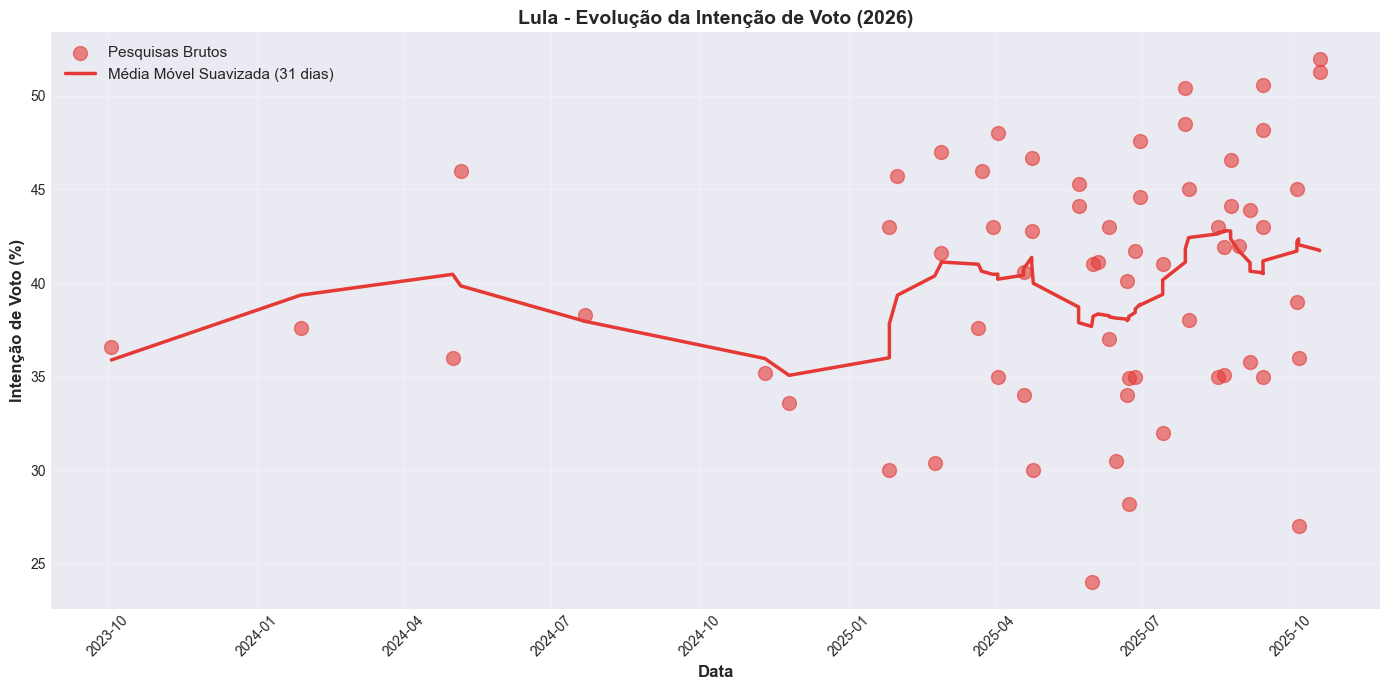


Estatísticas da Média Móvel Suavizada (Lula):
Mínimo: 35.06%
Máximo: 42.80%
Média: 40.01%


In [32]:
# Plotar
fig, ax = plt.subplots(figsize=(14, 7))

# Plotar pontos brutos
pontos_mask = ~pd.isna(lula_data['Lula'])
ax.scatter(df[df['Lula'].notna()]['data_parsed'], 
          df[df['Lula'].notna()]['Lula'],
          alpha=0.6, s=100, color='#e53935', label='Pesquisas Brutos', zorder=3)

# Plotar média móvel suavizada com interpolação cúbica
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

# Suavizar a média móvel usando Savitzky-Golay filter
# Remove valores NaN temporariamente
mascara_validos = ~np.isnan(media_movel)
indices_validos = np.where(mascara_validos)[0]
valores_validos_temp = media_movel[mascara_validos]

# Aplicar filtro Savitzky-Golay (window=7, polyorder=3)
if len(valores_validos_temp) > 7:
    media_movel_suavizada = savgol_filter(valores_validos_temp, window_length=7, polyorder=3)
else:
    media_movel_suavizada = valores_validos_temp

# Recolocar NaN nos lugares originais
media_movel_final = np.full_like(media_movel, np.nan)
media_movel_final[indices_validos] = media_movel_suavizada

# Pegar apenas os valores válidos
validos = ~np.isnan(media_movel_final)
datas_validas = df[validos]['data_parsed'].values
valores_validos = media_movel_final[validos]

# Converter datas para números para interpolação
datas_num = np.arange(len(df['data_parsed']))
datas_num_validas = datas_num[validos]

# Interpolação cúbica suave
if len(valores_validos) > 3:
    f_interp = interp1d(datas_num_validas, valores_validos, kind='cubic', fill_value='extrapolate')
    datas_num_interpolado = np.linspace(datas_num_validas[0], datas_num_validas[-1], 200)
    valores_interpolado = f_interp(datas_num_interpolado)
    datas_interpolado = df['data_parsed'].iloc[datas_num_validas[0]:datas_num_validas[-1]].iloc[::len(datas_num_interpolado)//50]
    
    ax.plot(df['data_parsed'].iloc[datas_num_validas], valores_validos, 
           linewidth=2.5, color='#e53935', label='Média Móvel Suavizada (31 dias)', zorder=2)
else:
    ax.plot(df['data_parsed'], media_movel_final, 
           linewidth=2.5, color='#e53935', label='Média Móvel Suavizada (31 dias)', zorder=2)

# Configurar
ax.set_xlabel('Data', fontsize=12, fontweight='bold')
ax.set_ylabel('Intenção de Voto (%)', fontsize=12, fontweight='bold')
ax.set_title('Lula - Evolução da Intenção de Voto (2026)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nEstatísticas da Média Móvel Suavizada (Lula):")
print(f"Mínimo: {np.nanmin(media_movel_final):.2f}%")
print(f"Máximo: {np.nanmax(media_movel_final):.2f}%")
print(f"Média: {np.nanmean(media_movel_final):.2f}%")

In [ ]:
from scipy.signal import savgol_filter

# Suavizar a média móvel usando Savitzky-Golay filter
# Remove valores NaN temporariamente
mascara_validos = ~np.isnan(media_movel)
indices_validos = np.where(mascara_validos)[0]
valores_validos = media_movel[mascara_validos]

# Aplicar filtro Savitzky-Golay (window=7, polyorder=3)
if len(valores_validos) > 7:
    media_movel_suavizada = savgol_filter(valores_validos, window_length=7, polyorder=3)
else:
    media_movel_suavizada = valores_validos

# Recolocar NaN nos lugares originais
media_movel_final = np.full_like(media_movel, np.nan)
media_movel_final[indices_validos] = media_movel_suavizada

print(f"Média móvel suavizada calculada!")
print(f"Comparação (primeiros 10 valores):\")\ndf_compare = pd.DataFrame({\n    'Data': df['data_parsed'][:10],\n    'Bruto': media_movel[:10],\n    'Suavizado': media_movel_final[:10]\n})\nprint(df_compare.to_string())

In [ ]:
# Criar DataFrame com resultados
resultado = pd.DataFrame({
    'Data': df['data_parsed'],
    'Pesquisa Bruta': df['Lula'],
    'Média Móvel': media_movel,
    'Média Móvel Suavizada': media_movel_final,
    'Instituto': df['instituto']
})

# Mostrar últimas 10 linhas
print("Últimas 10 linhas com média móvel:")
print(resultado.tail(10).to_string())

# Salvar como CSV
resultado.to_csv('lula_media_movel.csv', index=False)
print("\n✓ Dados salvos em 'lula_media_movel.csv'")


Últimas 10 linhas com média móvel:
         Data  Pesquisa Bruta  Média Móvel   Instituto
54 2025-09-14            43.0    40.658824      Quaest
55 2025-09-14            48.2    40.658824  AtlasIntel
56 2025-09-14            35.0    40.658824      Quaest
57 2025-09-14            50.6    40.658824  AtlasIntel
58 2025-10-05            45.0    42.233333      Quaest
59 2025-10-05            39.0    42.233333      Quaest
60 2025-10-06            36.0    42.233333        Gerp
61 2025-10-06            27.0    42.233333        Gerp
62 2025-10-19            52.0    41.716667  AtlasIntel
63 2025-10-19            51.3    41.716667  AtlasIntel

✓ Dados salvos em 'lula_media_movel.csv'
